**Note:** the recommended standard workflow is

- shuffle
- repeat (repeat after shuffle so that one epoch = all the examples)
- map, using the num_parallel_calls argument to get multithreading for free.
- batch or padded_batch
- prefetch (will prefetch data on the GPU so that it doesn't suffer from any data starvation – and only use 80% of your expensive GPU).


# keras
https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11

Input: 
https://www.kaggle.com/snlpnkj/bidirectional-lstm-keras !!!

# TODO
- test

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sn
import pickle as pkl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical

DATA_DIR = "../Data/4ner/"
OBJECTS_DIR = '../objects/'
PROCESSED_TRAIN_DATA_DIR = '../Data/processed/'
PROCESSED_TEST_DATA_DIR = '../Data/processed_test_data/'
LOG_DIR  = '../log/bioc_FH_training/'

In [2]:
def load_ner_data(path, mode):
    words = Path(path) / f"{mode}.words.txt"
    tags = Path(path) / f"{mode}.tags.txt"
    
    with Path(words).open('r') as f_words, Path(tags).open('r') as f_tags:
        X, y = [], []
        for line_words, line_tags in zip(f_words, f_tags):
            line_words = line_words.strip().split()
            line_tags = line_tags.strip().split()
            assert len(line_words) == len(line_tags)
            X.append(line_words[2:])
            y.append(line_tags[2:])
    return X, y

X_ner_train, y_ner_train = load_ner_data(DATA_DIR, 'train_doc')
X_ner_valid, y_ner_valid = load_ner_data(DATA_DIR, 'valid_doc')

In [3]:
## elmo embedding
# with open(join(PROCESSED_DIR, 'doc_156.emb.pkl'),'rb') as f:
#     doc = pkl.load(f)

In [4]:
def load_words_dict(path):
    file = Path(path) / "vocab.words.txt"
    words_dict = {"<PAD>": 0}
    
    with file.open() as f_words:
        for idx, word in enumerate(f_words):
            word = word.strip()
            words_dict[word] = idx + 1
    return words_dict


def load_tags_dict(path):
    file = Path(path) / "vocab.tags.txt"
    tags_dict = {}
    tags_dict['<pad>'] = 0
    
    with file.open() as f_tags:
        for idx, line in enumerate(f_tags):
            tag = line.strip()
            tags_dict[tag] = idx + 1

    return tags_dict


tags_dict = load_tags_dict(DATA_DIR)
print(tags_dict)
words_index = load_words_dict(DATA_DIR)
print(len(words_index))

{'<pad>': 0, 'FM': 1, 'LS-0': 2, 'LS-2': 3, 'LS-4': 4, 'Maternal': 5, 'O': 6, 'OBS': 7, 'Paternal': 8}
2212


In [5]:
def sent2seq(words_index, X, tags_dict, y):
    X_seq, y_seq = [], []
    for sent, tags in zip(X, y):
        sent_seq, tags_seq = [], []

        for word, tag in zip(sent, tags):
            if word.strip():     # skip ' '
                sent_seq.append(words_index[word])
                tags_seq.append(tags_dict[tag])
        assert len(sent_seq) == len(tags_seq)
        X_seq.append(sent_seq)
        y_seq.append(np.expand_dims(tags_seq, axis=1))
    return X_seq, y_seq

In [6]:
max_features = 25000  # how many unique words to use
maxlen = 55           # max num of words in one training record

X_train_seq, y_train_seq = sent2seq(words_index, X_ner_train, tags_dict, y_ner_train)
X_valid_seq, y_valid_seq = sent2seq(words_index, X_ner_valid, tags_dict, y_ner_valid)

len_X_train = list(map(len, X_train_seq))
len_X_valid = list(map(len, X_valid_seq))
print("Train: avg length:", np.mean(len_X_train), "\nmax:", np.max(len_X_train))
print("Valid: avg length:", np.mean(len_X_valid), "\nmax:", np.max(len_X_valid))

X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_valid = pad_sequences(X_valid_seq, maxlen=maxlen, padding='post')
y_train = pad_sequences(y_train_seq, maxlen=maxlen, padding='post')
y_valid = pad_sequences(y_valid_seq, maxlen=maxlen, padding='post')

Train: avg length: 14.5722049689441 
max: 63
Valid: avg length: 15.791044776119403 
max: 54


In [7]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
# print(X_train[0])
# print(y_train[0])

x_train shape: (1288, 55)
y_train shape: (1288, 55, 1)
X_valid shape: (469, 55)
y_valid shape: (469, 55, 1)


In [8]:
embedding_size = 100
EMBEDDING_FILE = Path.home() / f"tools/glove/glove.6B.{embedding_size}d.txt"

In [9]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [10]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

embedding_matrix = np.random.normal(emb_mean, emb_std,
                                    (max_features, embedding_size))
for word, i in words_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [11]:
embedding = Embedding(max_features, embedding_size, input_length=maxlen, mask_zero=True)

def model_LSTM(embedding, output, activation='softmax'):
    model = Sequential()
    # modify as elmo embedding layer,
    # with shape (batch_size, seq_len, dim)
    model.add(embedding)
    model.add(Bidirectional(LSTM(128,
                                 return_sequences=True,
                                 input_shape=(maxlen, embedding_size),
                                 dropout=0.5,
                                 recurrent_dropout=0.5)))
    model.add(Dense(output, activation=activation))
    model.compile(optimizer='adam', # Rmsprop opt for RNN model  # 'adam',
                  loss='sparse_categorical_crossentropy', # [32]
                  metrics=['acc'])
    print(model.summary())
    return model

model = model_LSTM(embedding, len(tags_dict))

W0928 06:16:52.574711 140326845466368 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0928 06:16:52.596424 140326845466368 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0928 06:16:52.703196 140326845466368 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 100)           2500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 55, 256)           234496    
_________________________________________________________________
dense (Dense)                (None, 55, 9)             2313      
Total params: 2,736,809
Trainable params: 2,736,809
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
print('Training...')
batch_size = 32
epochs = 15
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=[X_valid, y_valid])

Training...


W0928 06:16:56.045085 140326845466368 deprecation.py:323] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:457: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 1288 samples, validate on 469 samples
Epoch 1/15
1288/1288 [==============================] - 9s 7ms/sample - loss: 0.3114 - acc: 0.8505 - val_loss: 0.1604 - val_acc: 0.8852
Epoch 2/15
1288/1288 [==============================] - 5s 4ms/sample - loss: 0.1436 - acc: 0.8766 - val_loss: 0.1366 - val_acc: 0.8852
Epoch 3/15
1288/1288 [==============================] - 5s 4ms/sample - loss: 0.1181 - acc: 0.8767 - val_loss: 0.1095 - val_acc: 0.8877
Epoch 4/15
1288/1288 [==============================] - 5s 4ms/sample - loss: 0.0893 - acc: 0.8879 - val_loss: 0.0890 - val_acc: 0.8983
Epoch 5/15
1288/1288 [==============================] - 5s 4ms/sample - loss: 0.0707 - acc: 0.9066 - val_loss: 0.0809 - val_acc: 0.9006
Epoch 6/15
1288/1288 [==============================] - 5s 4ms/sample - loss: 0.0610 - acc: 0.9215 - val_loss: 0.0760 - val_acc: 0.9079
Epoch 7/15
1288/1288 [==============================] - 6s 4ms/sample - loss: 0.0527 - acc: 0.9334 - val_loss: 0.0684 - val_acc: 0.9186
E

# Visulizing results of the training

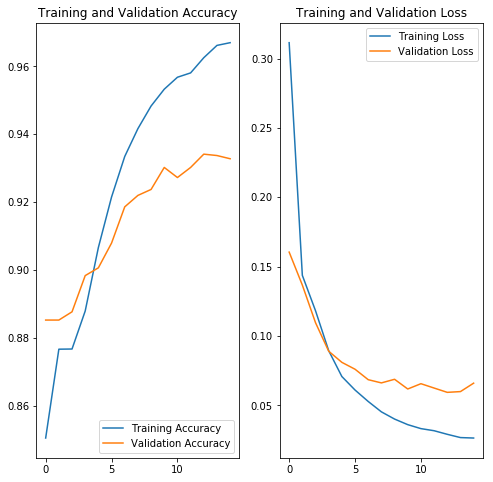

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./acc-loss.png')
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
# # prediction_probas = model.predict(X_valid) 

num2tag = {v:k for k, v in tags_dict.items()}

predictions = model.predict(X_valid)
predictions = [[np.argmax(word_pred) for word_pred in sent_pred] for sent_pred in predictions]

for idx, instance in enumerate(X_valid_seq):
    assert len(X_valid_seq[idx]) == len(y_valid_seq[idx]), f"at idx {idx}"
    predictions[idx] = predictions[idx][:len(instance)]
    
line, total, wrong = 0, 0, 0
print("word\t\tTrue\t\tPredicted")
for preds, seq in zip(predictions, y_valid_seq):
    seq = np.squeeze(seq, axis=1).tolist()
    
    for idx, (pred, label) in enumerate(zip(preds, seq)):
        if pred != label:
            wrong += 1
            print(f"{X_ner_valid[line][idx]}\t\t{y_ner_valid[line][idx]}\t\t{num2tag[pred]}")
    line += 1
    total += idx + 1
print(wrong, "wrong out of", total)

word		True		Predicted
asthma		OBS		O
daughter		Maternal		O
TAR		OBS		O
died		O		LS-0
died		O		LS-0
schizophrenia		O		OBS
schizophrenia		O		OBS
cousin		Maternal		O
craft		OBS		O
neurosis		OBS		O
thalassemia		OBS		O
died		LS-2		LS-0
graft		OBS		O
site		OBS		O
son		FM		O
duplication		OBS		O
2q		OBS		O
grade		OBS		O
obstruction		OBS		O
arboviral		OBS		O
good		LS-4		O
health		LS-4		O
conduction		OBS		O
adenocarcinoma		OBS		O
disorders		OBS		O
of		OBS		O
lump		OBS		O
of		OBS		O
maligprostate		OBS		O
benign		O		OBS
hurler		OBS		O
men		OBS		O
ii		OBS		O
phaeochromocytoma		OBS		O
choreic		OBS		O
dysphonia		OBS		O
aunt		O		Paternal
enamel		O		OBS
caries		O		OBS
daughter		O		FM
uncle		O		Paternal
died		O		LS-0
rheumatoid		O		OBS
arthritis		O		OBS
smoker		O		OBS
alcohol		O		OBS
aunt		O		Maternal
heart		O		OBS
died		O		LS-0
hysterectomy		OBS		O
passed		LS-0		O
away		LS-0		O
aunt		O		Maternal
cancer		O		OBS
son		O		FM
skin		O		OBS
cancer		O		OBS
died		O		LS-0
smoker		O		OBS
aunt		O		Maternal
passed	

[[  84    0    0    1    2   47    0    1]
 [   0   47    0    0    0   18    0    0]
 [   0    1    0   15    0   10    0    0]
 [   0    0    0   27    0   32    0    0]
 [   6    0    0    0   42   13    0    0]
 [  27   10    0    5    7 6451   51    5]
 [   0    0    0    0    0  231  227    0]
 [   0    0    0    0    1   15    0   30]]
              precision    recall  f1-score   support

           1      0.718     0.622     0.667       135
           2      0.810     0.723     0.764        65
           3      0.000     0.000     0.000        26
           4      0.562     0.458     0.505        59
           5      0.808     0.689     0.743        61
           6      0.946     0.984     0.965      6556
           7      0.817     0.496     0.617       458
           8      0.833     0.652     0.732        46

   micro avg      0.933     0.933     0.933      7406
   macro avg      0.687     0.578     0.624      7406
weighted avg      0.925     0.933     0.926      7406



/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


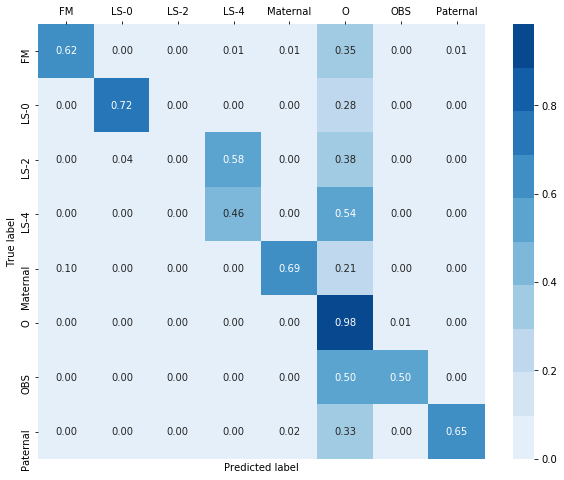

In [15]:
true_valid = [label[0] for labels in y_valid_seq for label in labels]
pred_valid = [label for labels in predictions for label in labels]

print(confusion_matrix(true_valid, pred_valid))

classes = list(tags_dict.keys())

cm = confusion_matrix(y_true=true_valid, y_pred=pred_valid)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=classes[1:], columns=classes[1:])
plt.figure(figsize=(10,8))
ax = sn.heatmap(df_cm, annot=True, fmt='.2f',cmap=sn.color_palette("Blues", n_colors=10))
ax.set(ylabel='True label', xlabel='Predicted label')
ax.xaxis.tick_top()
print(classification_report(true_valid, pred_valid, digits=3))

# Test